In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import tqdm
import nltk 

In [62]:
#reading data
df = pd.read_csv('hospitalreview.csv')

df.head()

,id,hospital_name,rating,review
0,1,Serene Medical Center,5,Serene Medical Center deserves nothing less th...
1,2,Harmony General Hospital,2,Harmony General Hospital was a disappointment....
2,3,Sunrise Healthcare,4,Sunrise Healthcare provided exceptional care. ...
3,4,Tranquil Medical Center,3,Tranquil Medical Center was average. The staff...
4,5,Sacred Heart Hospital,5,Sacred Heart Hospital exceeded my expectations...


## QUICK EDA

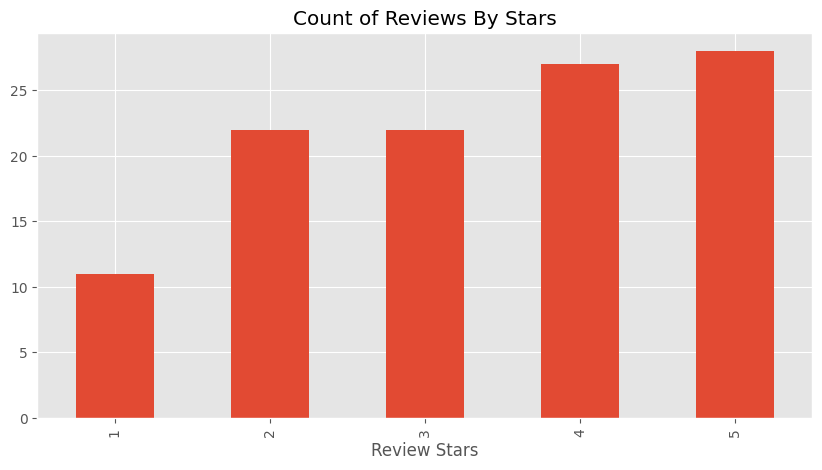

In [63]:
ax = df['rating'].value_counts().sort_index().plot(kind = 'bar', title='Count of Reviews By Stars',
                                              figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

## BASIC NLTK

In [64]:
example = df['review'][50]
print(example)

Tranquility Medical Center fell short of expectations. The staff seemed disinterested, and the facilities were in need of updates.


In [65]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Tranquility',
 'Medical',
 'Center',
 'fell',
 'short',
 'of',
 'expectations',
 '.',
 'The',
 'staff']

In [66]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Tranquility', 'NNP'),
 ('Medical', 'NNP'),
 ('Center', 'NNP'),
 ('fell', 'VBD'),
 ('short', 'JJ'),
 ('of', 'IN'),
 ('expectations', 'NNS'),
 ('.', '.'),
 ('The', 'DT'),
 ('staff', 'NN')]

In [67]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Tranquility/NNP
  Medical/NNP
  (PERSON Center/NNP)
  fell/VBD
  short/JJ
  of/IN
  expectations/NNS
  ./.
  The/DT
  staff/NN
  seemed/VBD
  disinterested/JJ
  ,/,
  and/CC
  the/DT
  facilities/NNS
  were/VBD
  in/IN
  need/NN
  of/IN
  updates/NNS
  ./.)


### VADER SENTIMENT SCORING

##### VADER = Valence Aware Dictionary and Sentiment Reasoner

###### stop words are removed such as "and", "the"

In [68]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

### compound is measured -1 to 1 to see how negative or positive it is

In [69]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [70]:
sia.polarity_scores('This is the worst thing ever!')

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [71]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.4215}

## RUN THE POLARITY SCORE ON THE ENTIRE DATASET

In [72]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)
    

  0%|          | 0/110 [00:00<?, ?it/s]

In [73]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [74]:
# Sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,hospital_name,rating,review
0,1,0.000,0.735,0.265,0.7574,Serene Medical Center,5,Serene Medical Center deserves nothing less th...
1,2,0.258,0.606,0.136,-0.3400,Harmony General Hospital,2,Harmony General Hospital was a disappointment....
2,3,0.000,0.588,0.412,0.8442,Sunrise Healthcare,4,Sunrise Healthcare provided exceptional care. ...
3,4,0.000,0.658,0.342,0.6956,Tranquil Medical Center,3,Tranquil Medical Center was average. The staff...
4,5,0.000,0.824,0.176,0.4939,Sacred Heart Hospital,5,Sacred Heart Hospital exceeded my expectations...


## PLOT VADER RESULTS

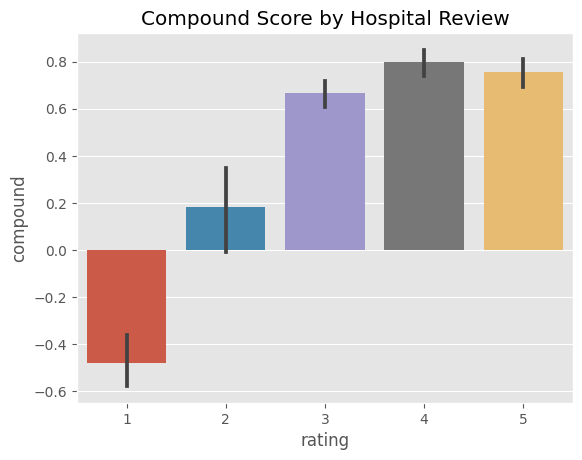

In [75]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by Hospital Review')
plt.show()

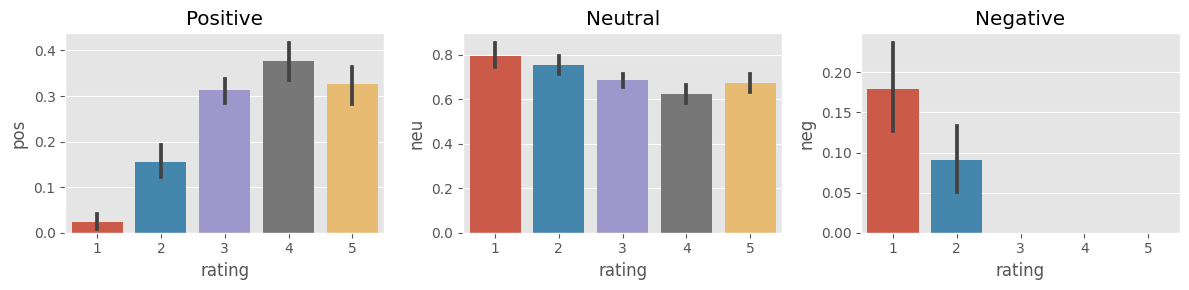

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Positivity is higher as the score is higher, Neutral is flat, and it becomes less negative as star review becomes higher

# ROBERTA PRETRAINED MODEL

In [77]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [78]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [79]:
#VADER results on example
print(example)
sia.polarity_scores(example)

Tranquility Medical Center fell short of expectations. The staff seemed disinterested, and the facilities were in need of updates.


{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.4215}

In [80]:
# Run on Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.8719569, 'roberta_neu': 0.11957436, 'roberta_pos': 0.008468699}


In [81]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [82]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result, **roberta_result}
    res[myid] = both

  0%|          | 0/110 [00:00<?, ?it/s]

In [83]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

In [84]:
results_df.head()

,id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,hospital_name,rating,review
0,1,0.000,0.735,0.265,0.7574,0.006799,0.045209,0.947992,Serene Medical Center,5,Serene Medical Center deserves nothing less th...
1,2,0.258,0.606,0.136,-0.3400,0.975646,0.022293,0.002061,Harmony General Hospital,2,Harmony General Hospital was a disappointment....
2,3,0.000,0.588,0.412,0.8442,0.001469,0.021160,0.977371,Sunrise Healthcare,4,Sunrise Healthcare provided exceptional care. ...
3,4,0.000,0.658,0.342,0.6956,0.598165,0.351175,0.050660,Tranquil Medical Center,3,Tranquil Medical Center was average. The staff...
4,5,0.000,0.824,0.176,0.4939,0.004692,0.038401,0.956907,Sacred Heart Hospital,5,Sacred Heart Hospital exceeded my expectations...


## TRANSFORMERS PIPELINE

In [85]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [86]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [87]:
sent_pipeline('I hate how pretty you are that it makes me so happy')

[{'label': 'POSITIVE', 'score': 0.9995911717414856}]